In [1]:
N_CLASSES = 43
RESIZED_IMAGE=(32, 32)

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
import os
np.random.seed(101)
%matplotlib inline

Dataset = namedtuple('Dataset', ['X','y'])

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
    for c in range(n_labels):
        full_path = rootpath + os.path.sep + format(c, '05d') + os.path.sep
        for img_name in glob.glob(full_path + '*.ppm'):
            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img / 255.0)[:, :, 0]
            if resize_to:
                img = resize(img, resize_to, mode = 'reflect')
            label = np.zeros((n_labels, ), dtype=np.float32)
            label[c] = 1.0
            
            images.append(img.astype(np.float32))
            labels.append(label)
    return Dataset(X = to_tf_format(images).astype(np.float32),
                  y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


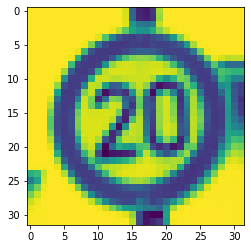

In [31]:
plt.imshow(dataset.X[0,:,:,:].reshape(RESIZED_IMAGE))
print(dataset.y[0,:])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


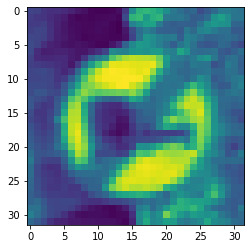

In [4]:
plt.imshow(dataset.X[-1,:,:,:].reshape(RESIZED_IMAGE))
print(dataset.y[-1,:])

In [24]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=.25, random_state=101)
X_train = dataset.X[idx_train,:,:,:]
X_test = dataset.X[idx_test,:,:,:]
y_train = dataset.y[idx_train,:]
y_test = dataset.y[idx_test,:]

print(X_train.shape)
print(y_train.shape)

(29406, 32, 32, 1)
(29406, 43)


In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
print(X_test.shape)
print(y_test.shape)

(9803, 32, 32, 1)
(9803, 43)


In [51]:
image_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale= 1./255,
    validation_split=.25,
    tes
)

In [52]:
training_data = image_generator.flow_from_directory('./GTSRB/Final_Training/Images/',
                                                        color_mode="grayscale",
                                                        batch_size=64,
                                                        target_size=(32, 32),
                                                        shuffle=True,
                                                        seed=1132,
                                                   subset='training')

Found 29416 images belonging to 43 classes.


In [ ]:
test_data = image_generator.flow_from_directory('./GTSRB/Final_Training/Images/',
                                                        color_mode="grayscale",
                                                        batch_size=64,
                                                        target_size=(32, 32),
                                                        shuffle=True,
                                                        seed=1132,
                                                   subset='validation')

In [53]:
validation_data = image_generator.flow_from_directory('./GTSRB/Final_Training/Images/',
                                                        color_mode="grayscale",
                                                        batch_size=64,
                                                        target_size=(32, 32),
                                                        shuffle=True,
                                                        seed=1132,
                                                   subset='validation')

Found 9793 images belonging to 43 classes.


In [47]:
image_generator.

# Auto Encoder
- 결론 : 좋지 않은 성능을 보임


In [13]:
# auto encoder
_, image_height, image_width, channel = X_train.shape

In [42]:

conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(image_height, image_width, channel)),
    keras.layers.GaussianNoise(0.1),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(500, activation='sigmoid'),
    keras.layers.Dense(43, activation='softmax'),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Dense(500, activation='sigmoid', input_shape=(43,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4*4*64, activation='sigmoid'),
    keras.layers.Reshape([4,4,64]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(channel, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Reshape([image_height, image_width, channel])
])

In [43]:
conv_encoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_9 (GaussianNo (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 32)        

In [44]:
conv_decoder.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               22000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              513024    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 32)          18464     
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 16, 16, 16)        4624      
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 16, 16)      

In [45]:
conv_auto_encoder = keras.models.Sequential([conv_encoder, conv_decoder])

In [46]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [47]:
early_stopped = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint('convolution_auto_encoder.h5', save_best_only=True)
conv_auto_encoder.fit(
#     image_generator.flow(X_train_norm, y_train, batch_size=64),
    X_train_norm, X_train_norm,
    epochs=100,
    callbacks=[early_stopped, check_point],
    validation_split=.1
)

Epoch 1/100
828/828 [==============================] - 26s 31ms/step - loss: 0.8010 - val_loss: 0.6762
Epoch 2/100
828/828 [==============================] - 26s 31ms/step - loss: 0.6519 - val_loss: 0.6407
Epoch 3/100
828/828 [==============================] - 26s 31ms/step - loss: 0.6165 - val_loss: 0.4364
Epoch 4/100
828/828 [==============================] - 26s 31ms/step - loss: 0.3697 - val_loss: 0.3585
Epoch 5/100
828/828 [==============================] - 26s 32ms/step - loss: 0.4048 - val_loss: 0.3583
Epoch 6/100
828/828 [==============================] - 26s 31ms/step - loss: 0.3588 - val_loss: 0.3572
Epoch 7/100
828/828 [==============================] - 26s 31ms/step - loss: 0.3581 - val_loss: 0.3556
Epoch 8/100
828/828 [==============================] - 26s 31ms/step - loss: 0.3738 - val_loss: 0.3684
Epoch 9/100
828/828 [==============================] - 26s 31ms/step - loss: 0.3620 - val_loss: 0.3547
Epoch 10/100
828/828 [==============================] - 26s 31ms/step - l

In [146]:
for_show_output = [0]

In [147]:
for_show_output.shape

(32, 32, 1)

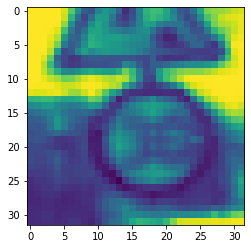

In [148]:
plt.imshow(for_show_output[:,:,0])

In [149]:
for_show_output_pred = conv_auto_encoder.predict(for_show_output.reshape(1,32,32,1))

In [150]:
for_show_output_pred.shape

(1, 32, 32, 1)

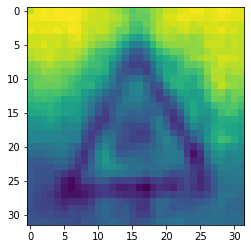

In [151]:
plt.imshow(for_show_output_pred[0][:,:,0])

In [63]:
test_dataset_pred = conv_encoder.predict_classes(X_test_norm)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [86]:
test_dataset_pred.shape

(9803,)

In [121]:
np.array(y_test.argmax(axis=1))[:,0].shape

(9803,)

In [67]:
from sklearn.metrics import confusion_matrix
unsupervised_auto_encoder = confusion_matrix(test_dataset_pred, y_test.argmax(axis=1))

In [138]:
import pandas as pd
unsupervised_auto_encoder = pd.DataFrame([test_dataset_pred, np.array(y_test.argmax(axis=1))[:,0]])

In [139]:
unsupervised_auto_encoder = unsupervised_auto_encoder.T
unsupervised_auto_encoder.columns = ['true','auto_encoder']

In [140]:
unsupervised_auto_encoder['cnt'] = 1

In [141]:
unsupervised_auto_encoder_grouped = unsupervised_auto_encoder.groupby(['true','auto_encoder']).count()

In [142]:
unsupervised_auto_encoder_grouped= unsupervised_auto_encoder_grouped.reset_index()

In [144]:
rs = unsupervised_auto_encoder_grouped.pivot_table(index='true', columns='auto_encoder',values='cnt')

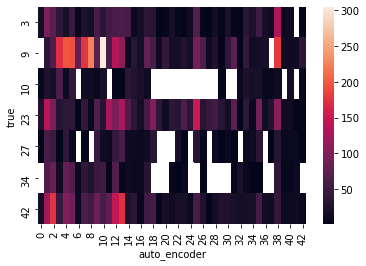

In [145]:
import seaborn as sns
sns.heatmap(rs)

# CNN


In [39]:
convolution_model = keras.models.Sequential([
    keras.layers.Conv2D(16, 7, padding='same', activation='relu', input_shape=(image_height, image_width, channel)),
    keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(43, activation='softmax'),
])

In [40]:
convolution_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 16)        800       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        25632     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)         

In [41]:
convolution_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
convolution_model.fit_generator(
    training_data, epochs=200, 
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), keras.callbacks.ModelCheckpoint('cnn_base.h5', save_best_only=True)],
    validation_data=validation_data
)

Epoch 1/200
460/460 [==============================] - 83s 181ms/step - loss: 2.3882 - accuracy: 0.3153 - val_loss: 2.0037 - val_accuracy: 0.4995
Epoch 2/200
460/460 [==============================] - 83s 180ms/step - loss: 0.6253 - accuracy: 0.8019 - val_loss: 0.7208 - val_accuracy: 0.7991
Epoch 3/200
460/460 [==============================] - 82s 178ms/step - loss: 0.2787 - accuracy: 0.9134 - val_loss: 0.5381 - val_accuracy: 0.8584
Epoch 4/200
460/460 [==============================] - 82s 178ms/step - loss: 0.1943 - accuracy: 0.9411 - val_loss: 0.4256 - val_accuracy: 0.8894
Epoch 5/200
460/460 [==============================] - 81s 177ms/step - loss: 0.1398 - accuracy: 0.9564 - val_loss: 0.5607 - val_accuracy: 0.8703
Epoch 6/200
460/460 [==============================] - 82s 178ms/step - loss: 0.1249 - accuracy: 0.9629 - val_loss: 0.4752 - val_accuracy: 0.8923
Epoch 7/200
460/460 [==============================] - 81s 177ms/step - loss: 0.1118 - accuracy: 0.9665 - val_loss: 0.6360 -